In [13]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append("../utils/")

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, MaxAbsScaler, RobustScaler

from GraphAPI import GraphCreator
from graph_helpers import *
from evaluations import *

%aimport GraphAPI
%aimport graph_helpers
%aimport evaluations

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generating Graph from Entry Point

1. We initialize our GraphCreator class and check how many new nodes we will need to query. 

In [14]:
# include_see_also=False used for validation below.
# in deployment, include_see_also should be set to True
gc = GraphCreator("Function (music)",
                  include_see_also=False, max_recursive_requests=50)
print("Number of Links to Search:", len(gc.next_links), "\n\n")
print(list(gc.primary_nodes.keys()), "\n\n")
print(gc.see_also_articles)

Number of Links to Search: 178 


['Chord (music)', 'Tonal centre', 'Scale degree'] 


['Common practice period', 'Constant structure', 'Diatonic and chromatic', 'Nondominant seventh chord', 'Secondary dominant', 'Subsidiary chord', 'Roman numeral analysis']


2. We query all the nodes linked to/from the entry point (expand our network one level for each node).

In [15]:
gc.expand_network_threaded(threads=20, chunk_size=1)
print("Number of Links After Expansion: ", len(gc.graph.nodes))

Number of Links After Expansion:  54537


3. Since some nodes will likely have linked to articles through a redirect link, we need to traverse our graph and ensure that all redirects are assigned to the correct nodes. Once all redirects have been dealt with, we remove any old redirect nodes. 

In [16]:
gc.redraw_redirects()

4. Edges are weighted by how many categories two connected nodes have in common. Once we have all our nodes, and we have dealt with redirects, we can add edge weights for our entire graph. 

In [17]:
gc.update_edge_weights()
gc.get_edge_weights().head()

,source_node,target_node,edge_weight
0,Chord progression,Power chord,5
1,Ostinato,Figured bass,5
2,Figured bass,Ostinato,5
3,Power chord,Tone cluster,4
4,Terzschritt,Parallel and counter parallel,4


# Getting Our Feature Set

There are two options when generating the feature set:

1. we can generate a standard feature set with only the features themselves. To do this, have the `rank` parameter set to `False`.
2. We can generate a ranked feature set (set `rank` equal to `True`). For each parameter, this will rank them in order of _best_ to _worst_ (this could be ascending or descending, depending on the context of the feature).

After running `get_features_df`, the feature set will be saved in the GraphCreator instance as `feature_df`

In [18]:
features_df = gc.get_features_df(rank=False)

In [19]:
features_df

,node,degree,category_matches_with_source,in_edges,out_edges,shared_neighbors_with_entry_score,centrality,page_rank,adjusted_reciprocity,shortest_path_length_from_entry,shortest_path_length_to_entry,jaccard_similarity,primary_link
0,Function (music),240,1,116,124,1.000000,8.601906e-02,0.000615,0.100077,0.0,0.0,1.000000,0
1,Added tone chord,266,0,111,155,0.414414,7.014754e-02,0.000316,0.074603,1.0,1.0,0.544218,0
2,All-interval twelve-tone row,186,0,127,59,0.428571,1.206035e-01,0.000803,0.032752,1.0,2.0,0.509317,0
3,Altered chord,274,0,127,147,0.471154,9.461888e-02,0.000563,0.089159,1.0,1.0,0.537975,0
4,Approach chord,197,0,93,104,0.588235,1.101631e-01,0.000387,0.076422,1.0,1.0,0.632812,0
5,Arnold Schoenberg,2051,0,1604,447,0.013123,1.963999e-02,0.009820,0.228357,1.0,2.0,0.009390,0
6,Arpeggio,979,0,726,253,0.111374,9.194469e-02,0.003532,0.155574,1.0,1.0,0.109354,0
7,Augmented major seventh chord,191,0,87,104,0.575163,7.756488e-02,0.000265,0.072783,1.0,1.0,0.637097,0
8,Augmented seventh chord,192,0,89,103,0.581699,7.766204e-02,0.000270,0.072783,1.0,1.0,0.626984,0
9,Augmented sixth chord,289,0,112,177,0.442478,1.320683e-01,0.000537,0.084610,1.0,1.0,0.540541,0


# Similarity Rank

Two articles are more similar the more categories they share and the closer they are to each other. 

In [20]:
gc.rank_similarity()
gc.features_df.sort_values("similarity_rank", ascending=False)

,node,degree,category_matches_with_source,in_edges,out_edges,shared_neighbors_with_entry_score,centrality,page_rank,adjusted_reciprocity,shortest_path_length_from_entry,shortest_path_length_to_entry,jaccard_similarity,primary_link,similarity_rank
0,Function (music),240,1,116,124,1.000000,8.601906e-02,0.000615,0.100077,0.0,0.0,1.000000,0,5.337297
85,Predominant chord,117,1,16,101,0.650350,1.757677e-02,0.000114,0.010008,1.0,1.0,0.100000,0,1.398687
78,Parallel and counter parallel,220,1,100,120,0.645570,1.214702e-01,0.000517,0.081881,1.0,1.0,0.714286,0,1.344496
106,Supertonic,176,1,139,37,0.524324,8.876741e-02,0.000583,0.021835,1.0,1.0,0.574074,0,1.257649
105,Subtonic,181,1,128,53,0.507853,8.800567e-02,0.000537,0.020925,1.0,1.0,0.615894,0,1.235554
93,Secondary chord,298,1,115,183,0.570732,1.053472e-01,0.000632,0.096438,1.0,1.0,0.804688,0,1.175271
61,Mediant,212,1,167,45,0.443439,8.824851e-02,0.000694,0.020925,1.0,1.0,0.481675,0,1.140539
110,Terzschritt,49,1,21,28,0.191176,2.243963e-02,0.000176,0.015466,1.0,1.0,0.151261,0,1.134371
116,Tonicization,74,1,38,36,0.238095,1.436185e-02,0.000290,0.020015,1.0,1.0,0.203125,0,1.130013
103,Submediant,276,1,153,123,0.485981,8.780223e-02,0.000604,0.080061,1.0,1.0,0.528409,0,1.124588


# Scaling Features

We can easily scale our each of our features through the `scale_features_df` method. It will default to `Standard Scaler`, but we can specify alternate scalers in the `scaler` parameter.  

In [21]:
scaled_feature_df = gc.scale_features_df(scaler=Normalizer, copy=True) # Makes a copy of the df
scaled_feature_df.sort_values("similarity_rank", ascending=False).reset_index().drop("index", axis=1)

,node,similarity_rank,degree,category_matches_with_source,in_edges,out_edges,shared_neighbors_with_entry_score,centrality,page_rank,adjusted_reciprocity,shortest_path_length_from_entry,shortest_path_length_to_entry,jaccard_similarity,primary_link
0,Function (music),5.337297,0.816331,0.003401,0.394560,0.421771,0.003401,2.925835e-04,2.091111e-06,0.000340,0.000000,0.000000,0.003401,0.0
1,Predominant chord,1.398687,0.752891,0.006435,0.102960,0.649932,0.004185,1.131060e-04,7.322228e-07,0.000064,0.006435,0.006435,0.000643,0.0
2,Parallel and counter parallel,1.344496,0.815352,0.003706,0.370615,0.444738,0.002393,4.501861e-04,1.915837e-06,0.000303,0.003706,0.003706,0.002647,0.0
3,Supertonic,1.257649,0.774275,0.004399,0.611501,0.162774,0.002307,3.905134e-04,2.563101e-06,0.000096,0.004399,0.004399,0.002526,0.0
4,Subtonic,1.235554,0.794061,0.004387,0.561546,0.232515,0.002228,3.860877e-04,2.356887e-06,0.000092,0.004387,0.004387,0.002702,0.0
5,Secondary chord,1.175271,0.809490,0.002716,0.312387,0.497103,0.001550,2.861661e-04,1.717696e-06,0.000262,0.002716,0.002716,0.002186,0.0
6,Mediant,1.140539,0.774831,0.003655,0.610362,0.164469,0.001621,3.225361e-04,2.535209e-06,0.000076,0.003655,0.003655,0.001760,0.0
7,Terzschritt,1.134371,0.813390,0.016600,0.348596,0.464794,0.003173,3.724934e-04,2.916463e-06,0.000257,0.016600,0.016600,0.002511,0.0
8,Tonicization,1.130013,0.816243,0.011030,0.419152,0.397091,0.002626,1.584158e-04,3.194068e-06,0.000221,0.011030,0.011030,0.002241,0.0
9,Submediant,1.124588,0.814881,0.002952,0.451728,0.363153,0.001435,2.592332e-04,1.782340e-06,0.000236,0.002952,0.002952,0.001560,0.0


___
# Validation

Here, we _validate_ our results. For many articles, we already have some user defined links that are highly related to the present article. These are found in the **See Also** section of several Wikipedia articles (some pages do not have them). These are not ordered in importance in any meaningful way, and there are no rating scores.

The intuition in this validation is as follows: 

> _Given that we know some articles are highly related from user input, if the recommendations provided by this system are valid, we would expect to see those **See Also** links ranked relatively high on our list._ 

_Note: This validation is not meant as **confirmation** or **evaluation** of the results. It only provides us one way of telling if the results we are seeing are reasonably valid. It is important to note that we cannot compare these results across two different articles, as those would be two entirely different network structures, likely with different human labeled links._  


In [81]:
evaluation_df = evaluate_metrics(scaled_feature_df, 
                 on=[
                     "similarity_rank", 
                     "degree",
                     "category_matches_with_source",
                     "in_edges",
                     "out_edges",
                     "shared_neighbors_with_entry_score",
                     "centrality", 
                     "adjusted_reciprocity", 
                     "page_rank", 
                     "shortest_path_length_from_entry", 
                     "shortest_path_length_to_entry",
                     "jaccard_similarity"
                 ], 
                 targets=gc.see_also_articles).sort_values("score", ascending=False)
evaluation_df

Metric Score,score,max score possible,difference,total targets,% targets in top 1%,% targets in top 5%,% targets in top 10%,% targets in top 20%
similarity_rank,0.997479,0.99989,0.002411,6.0,1.000000,1.000000,1.000000,1.000000
degree,0.990614,0.99989,0.009276,6.0,1.000000,1.000000,1.000000,1.000000
in_edges,0.977013,0.99989,0.022877,6.0,0.333333,1.000000,1.000000,1.000000
adjusted_reciprocity,0.960412,0.99989,0.039477,6.0,0.500000,1.000000,1.000000,1.000000
centrality,0.940922,0.99989,0.058968,6.0,0.333333,0.500000,1.000000,1.000000
jaccard_similarity,0.909119,0.99989,0.090770,6.0,0.000000,0.333333,1.000000,1.000000
page_rank,0.898850,0.99989,0.101040,6.0,0.000000,0.166667,0.833333,1.000000
out_edges,0.731499,0.99989,0.268391,6.0,0.000000,0.666667,0.666667,0.666667
category_matches_with_source,0.332033,0.99989,0.667857,6.0,0.000000,0.000000,0.000000,0.000000
shortest_path_length_to_entry,0.000828,0.99989,0.999061,6.0,0.000000,0.000000,0.000000,0.000000


The chart generated above compares different ranking metrics (left index) for a given article. The most important column, `score`, provides a fast way for us to compare these different metrics. 

For example, if we see a _score_ of 0.98 for a given ranking metric, The following statement would be true:

> All of the human labeled **See Also** links are present within the top 98% of our recommendations. 

Since the human labeled links comprise a range, it is not possible to get a score of 100%. The `max score possible` column indicates the score that would be achieved if all the human labeled _See Also_ links appeared at the top of our recommendations without any other links intervening.   

The `difference` column is an alternative way of looking at the score. If we had a 0.02 in this column, we could say:

> All the human labeled **See Also** links are contained within the top 2% of our recommendations. 

`Total targets` is the number of human labeled _See Also_ links. 

Because it is possible that different metrics could have similar scores, we want a way to break down the dispersion of the known related links to see if one metric does perform better than another. The trailing four columns provide us with a course way of measuring this dispersion. 

Each of these columns indicates the percentage of human labeled _See Also_ links captured within a given percentage of the top of our recommendations. For example, if we see a 0.92 in the `% targets in the top 1%` columns, we could say:

> 92% of the human labeled **See Also** links appear in the top 1% of our recommendations. 

The value of these columns is a follows - If two ranking metrics have similar scores, we _might_ consider the better performing one to be the one in which the majority of the human labeled links are higher in our recommendation list. 

___

Index(['similarity_rank', 'degree', 'in_edges', 'adjusted_reciprocity',
       'centrality', 'jaccard_similarity', 'page_rank', 'out_edges',
       'category_matches_with_source', 'shortest_path_length_to_entry',
       'shortest_path_length_from_entry', 'shared_neighbors_with_entry_score'],
      dtype='object')


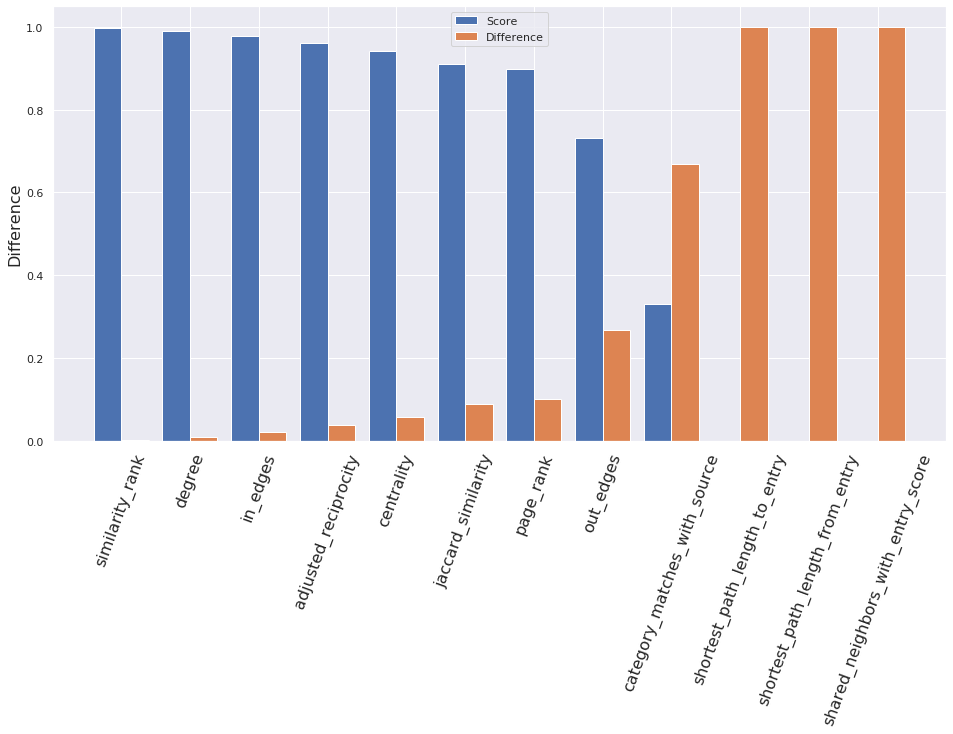

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
print(evaluation_df.index)
scores = evaluation_df.score
diffs = evaluation_df.difference

ind = np.arange(len(scores))
width = 0.4

fig, ax = plt.subplots(figsize=(16,8))

score_bars = ax.bar(ind - width/2, scores, width)
diff_bars = ax.bar(ind + width/2, diffs, width)

ax.set_xticks(np.arange(len(evaluation_df.index)))
ax.set_xticklabels(evaluation_df.index)

plt.xticks(fontsize=16, rotation=70)
plt.ylabel("Difference", fontsize=16)
plt.legend(["Score", "Difference"])
plt.show()